In [17]:
from calendar import c
import os
import cv2
import numpy as np

# Load the image
this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
img_path: str = os.path.join(assets_dir, "extrinsics/validation/left04.jpg")
intrinsics_path: str = os.path.join(assets_dir, "extrinsics/validation/left_intrinsics.yml")

img = cv2.imread(img_path)

# Copy the image for visualization
img_corners = img.copy()
img_pose = img.copy()
img_pose_pnp = img.copy()

pattern_size = (9, 6)
square_size = 0.025  # Adjust this value based on your chessboard square size

# Detect chessboard corners
found, corners = cv2.findChessboardCorners(img, pattern_size)

if found:
    # Compute object points
    object_points = []
    for i in range(pattern_size[1]):
        for j in range(pattern_size[0]):
            object_points.append([j * square_size, i * square_size, 0])
    object_points = np.array(object_points, dtype=np.float32)

    # Convert object points to 2D
    object_points_planar = object_points[:, :2]

    # Load camera parameters
    fs = cv2.FileStorage(intrinsics_path, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode('camera_matrix').mat()
    dist_coeffs = fs.getNode('distortion_coefficients').mat()

    # Undistort image points
    image_points = cv2.undistortPoints(corners, camera_matrix, dist_coeffs)

    # Estimate homography
    H, _ = cv2.findHomography(object_points_planar, image_points)

    print("H:\n", H)

    # Normalize homography matrix
    norm = np.linalg.norm(H[:, 0])
    H /= norm

    c1 = H[:, 0]
    c2 = H[:, 1]
    c3 = np.cross(c1, c2)

    tvec = H[:, 2]
    R = np.zeros((3, 3))
    R[:, 0] = c1
    R[:, 1] = c2
    R[:, 2] = c3

    # Orthogonalize rotation matrix using SVD
    U, _, Vt = np.linalg.svd(R)
    R = np.dot(U, Vt)
    if np.linalg.det(R) < 0:
        Vt[2, 0] *= -1
        Vt[2, 1] *= -1
        Vt[2, 2] *= -1
        R = np.dot(U, Vt)

    print("R (after polar decomposition):\n", R, f"det(R) = {np.linalg.det(R)}")
    print("tvec:\n", tvec)
    
else:
    print("Chessboard corners not found")


H:
 [[ 2.93381714 -0.03262346 -0.29719655]
 [-0.04478513  3.00291716 -0.20361019]
 [-0.71327145 -0.33612561  1.        ]]
R (after polar decomposition):
 [[ 0.97159413 -0.0113042   0.23638328]
 [-0.01535173  0.99374401  0.11062174]
 [-0.23615496 -0.11110832  0.96534231]] det(R) = 1.0
tvec:
 [-0.09842216 -0.0674293   0.33116859]


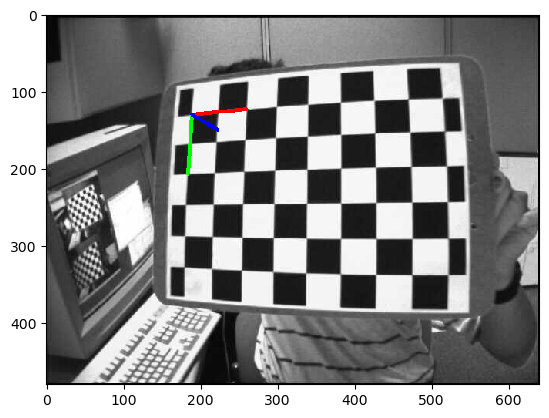

In [18]:
import cv2
from matplotlib import pyplot as plt

# Assuming R, tvec, cameraMatrix, distCoeffs, img_pose, and squareSize are already defined

# Convert rotation matrix to rotation vector
rvec, _ = cv2.Rodrigues(R)

# Draw frame axes
cv2.drawFrameAxes(img_pose, camera_matrix, dist_coeffs, rvec, tvec, 2 * square_size)

# Display the image
plt.imshow(cv2.cvtColor(img_pose, cv2.COLOR_BGR2RGB))

rvec:
 [[-0.11000735]
 [ 0.23929649]
 [-0.00194546]] tvec:
 [[-0.09839707]
 [-0.06736531]
 [ 0.33097659]]


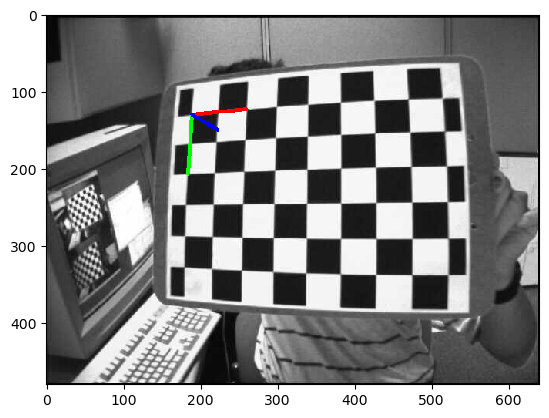

In [19]:
import cv2
from matplotlib import pyplot as plt

_, rvec, tvec = cv2.solvePnP(object_points, corners, camera_matrix, dist_coeffs)
# Assuming R, tvec, cameraMatrix, distCoeffs, img_pose, and squareSize are already defined

print("rvec:\n", rvec, "tvec:\n", tvec)

# Draw frame axes
cv2.drawFrameAxes(img_pose_pnp, camera_matrix, dist_coeffs, rvec, tvec, 2 * square_size)

# Display the image (convert BGR image to RGB)
plt.imshow(cv2.cvtColor(img_pose_pnp, cv2.COLOR_BGR2RGB))

# Validating `estimate_homography`

In [20]:
from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard, ReferenceFrame
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography
from dt_computer_vision.camera.types import CameraModel, Pixel

camera = CameraModel(
    width=img.shape[1],
    height=img.shape[0],
    K=camera_matrix,
    D=dist_coeffs,
    R=np.eye(3),
    P=camera_matrix,    
)

board = CalibrationBoard(
    rows=6,
    columns=9,
    square_size=square_size,
    x_offset=0,
    y_offset=0
    )

board_corners = board.corners(reference_frame=ReferenceFrame.BOARD)
board_corners_array = np.array([corner.as_array() for corner in board_corners])

# Check that the corners obtain from board.corners() match the ones expected by OpenCV (object_points_planar)
assert board_corners_array.shape == object_points_planar.shape, "Corners shape is not equal: {} != {}".format(corners.shape, object_points_planar.shape)
assert np.allclose(board_corners_array, object_points_planar), "Corners are not equal: {} != {}".format(corners, object_points_planar)

In [21]:
# Compute the image points to match to the chessboard
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners

ret, corners = cv2.findChessboardCorners(img, pattern_size)

dt_corners = find_corners(
    image=img,
    board=board,
)

dt_corners_array = np.asarray([corner.as_array() for corner in dt_corners])
# opencv wants corners in an array of shape [N, 1, 2]
dt_corners_array = np.expand_dims(dt_corners_array, axis=1)

def compute_max_difference(A : np.ndarray, B: np.ndarray):
    differences = np.abs(B - A)
    max_diff = np.max(differences)
    return max_diff

max_diff = compute_max_difference(corners, dt_corners_array)

print("Maximum difference:", max_diff)

assert dt_corners_array.shape == corners.shape, "Image points shape is not equal: {} != {}".format(dt_corners_array.shape, image_points.shape)
assert np.allclose(dt_corners_array, corners, atol=1, rtol = 1e-3), "Image points are not equal: {} != {}".format(dt_corners_array, image_points)


Maximum difference: 0.421875


In [22]:
# Verify that our of array of corners respects the OpenCV format
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import ImagePoints

cv2_rectified_dt_corners = cv2.undistortPoints(dt_corners_array, camera.K, camera.D)
assert cv2_rectified_dt_corners.shape == image_points.shape
assert np.allclose(cv2_rectified_dt_corners, image_points, atol=0.05, rtol=1e-3), "Rectified corners are not equal: {} != {}".format(cv2_rectified_dt_corners, image_points)

# Rectify the points
dt_rectified_corners : List[Pixel] = [camera.rectifier.rectify_pixel(corner) for corner in dt_corners]
dt_normalized_image_points : ImagePoints = [
    camera.pixel2vector(c) for c in dt_rectified_corners
    ]

dt_rectified_corners_array = np.expand_dims(
    np.asarray(
        [c.as_array() for c in dt_normalized_image_points]
    ),
    axis=1
    )

assert cv2_rectified_dt_corners.shape == dt_rectified_corners_array.shape

assert np.allclose(cv2_rectified_dt_corners, dt_rectified_corners_array, atol=1e-3), "Rectified corners are not equal: {} != {}".format(dt_rectified_corners_array, image_points)
assert np.allclose(dt_rectified_corners_array, image_points, atol=1e-3, rtol=1e-3), "Rectified corners are not equal: {} != {}".format(dt_rectified_corners_array, image_points)

diff = compute_max_difference(dt_rectified_corners_array, image_points)
print("Maximum difference:", diff)

Maximum difference: 0.0008700191520283895


In [23]:
# Verify that the homography is correct
# Restore H to original value
H *= norm

H_dt_cv2 = cv2.findHomography(board_corners_array, dt_rectified_corners_array)[0]
assert H_dt_cv2.shape == H.shape
assert np.allclose(H_dt_cv2, H, atol=2e-1, rtol=1e-3), "Homographies are not equal:\n{}\n!=\n{}".format(H_dt_cv2, H)

H_dt_computer_vision = estimate_homography(dt_rectified_corners, board, camera)
print("H_dt_computer_vision:\n", H_dt_computer_vision)

H_dt_computer_vision:
 [[0.33311621 0.01521772 0.10209929]
 [0.02169275 0.30907076 0.06933247]
 [0.24577665 0.11630193 1.        ]]


In [24]:
# H_dt_computer_vision = np.linalg.inv()
from numpy.linalg import inv
H_dt = H_dt_computer_vision

# We need to invert and re-normalize the matrix here
assert np.allclose(inv(H)/inv(H)[2,2], H_dt, atol=1e-1), \
    "Homography matrices are not equal: cv2\n{}dt_computer_vision\n{}".format(inv(H)/inv(H)[2,2], H_dt)

print("Homography matrices are equal")
print("H:\n", inv(H)/inv(H)[2,2])
print("H_duckietown_pipeline:\n", H_dt)

assert np.allclose(H, H_dt.inverse, atol=1e-1), \
    "Homography matrices are not equal: cv2\n{}dt_computer_vision\n{}".format(H, H_dt.inverse)

Homography matrices are equal
H:
 [[0.33313984 0.01504434 0.10207119]
 [0.0215716  0.30899929 0.06932641]
 [0.24486991 0.11459328 1.        ]]
H_duckietown_pipeline:
 [[0.33311621 0.01521772 0.10209929]
 [0.02169275 0.30907076 0.06933247]
 [0.24577665 0.11630193 1.        ]]


In [25]:
# Decompose homography matrix
solutions, Rs_decomp, ts_decomp, normals_decomp = cv2.decomposeHomographyMat(H_dt, camera.K)

for i in range(solutions):
    factor_d1 = 0# / d_inv1
    rvec_decomp, _ = cv2.Rodrigues(Rs_decomp[i])
    
    print(f"Solution {i}:")
    # print(f"rvec from homography decomposition: {rvec_decomp.T}")
    print(f"tvec from homography decomposition: {ts_decomp[i].T} and scaled by d: {factor_d1 * ts_decomp[i].T}")
    # print(f"plane normal from homography decomposition: {normals_decomp[i].T}")

Solution 0:
tvec from homography decomposition: [[-392.38901296 -270.06533632  614.61329938]] and scaled by d: [[-0. -0.  0.]]
Solution 1:
tvec from homography decomposition: [[ 392.38901296  270.06533632 -614.61329938]] and scaled by d: [[ 0.  0. -0.]]
Solution 2:
tvec from homography decomposition: [[-390.95434752 -269.38059487  615.82686242]] and scaled by d: [[-0. -0.  0.]]
Solution 3:
tvec from homography decomposition: [[ 390.95434752  269.38059487 -615.82686242]] and scaled by d: [[ 0.  0. -0.]]
